# Diagram showing VAE + GMM model 

Explain how the VAE + GMM model works with a simplified perceptron diagram.
This includes batch and time information. The ODE model results in a number of trajectories
which are used to compute GMM weights. Represent the latent space as a 1D real line, 
and plot a 1D guassian mixture that evolves with time according to the ODE model.

In [1]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import scipy.stats as sts
import matplotlib

import scdynsys.plots as plots
import scdynsys.utilities as utils


tex_fonts = {
    "font.family" : "Helvetica",
    'pdf.fonttype' : 42,
}

plt.rcParams.update(tex_fonts)

### Define some functions to organize the code a bit

Plotting the encoder and decoder networks

In [2]:
def plot_encoder(ax, n1, n2, n3, **kwargs):
    """
    Plot the envoder network. The number of nodes is given by
    n1, n2  and n3 (input, hidden, output)
    The encoder has batch and time information as additional input
    (as well as markers) and has location and scale parameters 
    as output.
    """
    d1 = n1/2
    d2 = n2/2
    d3 = n3/2
    dy = 0.2
    dx = 0.0
    y1s = np.linspace(-d1, d1, n1) if n1 > 1 else np.zeros(1)
    y2s = np.linspace(-d2, d2, n2) if n2 > 1 else np.zeros(1)
    y3s = np.linspace(-d3, d3, n3) if n3 > 1 else np.zeros(1)
    
    xb = 0.33
    yb = np.min(y2s)
    xt = 0.33
    yt = np.max(y2s)
    
    for y1 in y1s:
        for y2 in y2s:
            ax.plot([0, 1], [y1, y2], color='k', alpha=0.5, zorder=1)
    for y2 in y2s:
        for y3 in y3s:
            ax.plot([1, 2+dx], [y2, y3+dy], color='red', alpha=0.5, zorder=1)
            ax.plot([1, 2-dx], [y2, y3-dy], color='gray', alpha=0.5, zorder=1)
            
    ## batch correction input
    for y2 in y2s:
        ax.plot([xb, 1], [yb, y2], color='blue', alpha=0.5, zorder=1)

    ## time input 
    for y2 in y2s:
        ax.plot([xt, 1], [yt, y2], color='purple', alpha=0.5, zorder=1)
    
            
    ax.scatter(np.full(n1, 0), y1s, color='k', marker='s', zorder=2)
    ax.scatter(np.full(n2, 1), y2s, color='k', zorder=2)
    ax.scatter(np.full(n3, 2+dx), y3s+dy, color='r', zorder=2)
    ax.scatter(np.full(n3, 2-dx), y3s-dy, color='gray', zorder=2)
    ax.scatter([xb], [yb], color='blue', zorder=2, marker='s')
    ax.scatter([xt], [yt], color='purple', zorder=2, marker='s')
    
    
    dy_text = 0.4
    ax.text(0, np.min(y1s)-dy_text, "fluorescence ($x$)", fontsize=8, va='top', ha='center')
    ax.text(xb, yb-dy_text, "batch ($s$)", fontsize=8, va='top', ha='center')
    ax.text(xt, yt+dy_text/2, "time ($t$)", fontsize=8, va='bottom', ha='center')
    ax.text(1, np.min(y2s)-dy_text, "hidden\nlayer", fontsize=8, va='top', ha='center')
    ax.text(2, np.max(y3s)+dy_text, "mean ($\\mu_z$)", fontsize=8, va='bottom', ha='center', color='red')
    ax.text(2, np.min(y3s)-dy_text, "scale ($\\sigma_z$)", fontsize=8, va='top', ha='center', color='gray')
    ax.text(2, np.min(y3s)-2*dy_text, "latent ($z$)", fontsize=8, va='top', ha='center')
            

def plot_decoder(ax, n1, n2, n3, **kwargs):
    """
    Plot the envoder network. The number of nodes is given by
    n1, n2  and n3 (input, hidden, output)
    The encoder has batch additional input (as well as latent vectors) 
    and has location and scale parameters for marker expression as output.
    """
    d1 = n1/2
    d2 = n2/2
    d3 = n3/2
    dy = 0.2
    dx = 0.0
    y1s = np.linspace(-d1, d1, n1) if n1 > 1 else np.zeros(1)
    y2s = np.linspace(-d2, d2, n2) if n2 > 1 else np.zeros(1)
    y3s = np.linspace(-d3, d3, n3) if n3 > 1 else np.zeros(1)
    
    xb = 0.33
    yb = np.min(y2s)
    
    for y1 in y1s:
        for y2 in y2s:
            ax.plot([0, 1], [y1, y2], color='k', alpha=0.5, zorder=1)
    for y2 in y2s:
        for y3 in y3s:
            ax.plot([1, 2+dx], [y2, y3+dy], color='red', alpha=0.5, zorder=1)
            ax.plot([1, 2-dx], [y2, y3-dy], color='gray', alpha=0.5, zorder=1)
    ## batch correction input
    for y2 in y2s:
        ax.plot([xb, 1], [yb, y2], color='blue', alpha=0.5, zorder=1)

    ax.scatter(np.full(n1, 0), y1s, color='k', zorder=2)
    ax.scatter(np.full(n2, 1), y2s, color='k', zorder=2)
    ax.scatter(np.full(n3, 2+dx), y3s+dy, color='r', zorder=2, marker='s')
    ax.scatter(np.full(n3, 2-dx), y3s-dy, color='gray', zorder=2, marker='s')    
    ax.scatter([xb], [yb], color='blue', zorder=2, marker='s')
    
    dy_text = 0.4
    ax.text(0, np.min(y1s)-dy_text, "latent ($z$)", fontsize=8, va='top', ha='center')
    ax.text(xb, yb-dy_text, "batch ($s$)", fontsize=8, va='top', ha='center')
    ax.text(1, np.min(y2s)-dy_text, "hidden\nlayer", fontsize=8, va='top', ha='center')
    ax.text(2, np.max(y3s)+dy_text, "mean ($\\mu_x$)", fontsize=8, va='bottom', ha='center', color='red')
    ax.text(2, np.min(y3s)-dy_text, "scale ($\\sigma_x$)", fontsize=8, va='top', ha='center', color='gray')
    ax.text(2, np.min(y3s)-2*dy_text, "fluorescence ($x$)", fontsize=8, va='top', ha='center')

### Now make the diagram with encoder, latent space and decoder

The latent space represented with a 3D plot

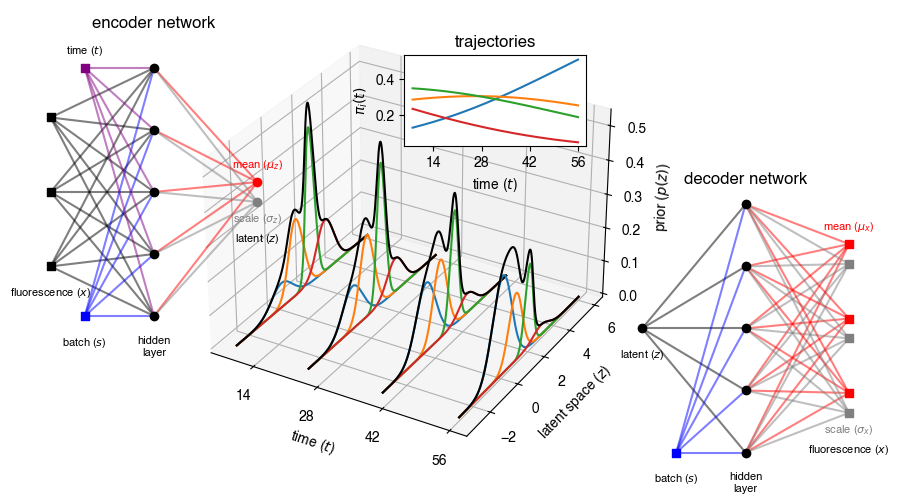

In [3]:
fig = plt.figure(figsize=(14,13))
gs = GridSpec(2,4)

# panel for the latent space: 3D plot!
ax = fig.add_subplot(gs[0,0:2], projection='3d')

ts = np.linspace(0, 1, 4)
T0 = 8 # re-label time axes to correspond with data

# define some arbitrary loss rates and initial population sizes
deltas = np.array([-1, -2.5, -3, -4])
logx0s = np.array([0.5, 1.3, 1.5, 1.1])

Xs = np.exp(np.outer(deltas, ts) + np.expand_dims(logx0s, axis=1))

# weights for the GMM model
pis = Xs / np.sum(Xs, axis=0, keepdims=True)

# means and scales for the GMM model
mus = np.array([0, 1, 2, 3])
sigmas = np.array([0.7, 0.5, 0.3, 0.6])

# compute the GMM densities
zs = np.linspace(-3, 6, 1000)
fs = [sts.norm.pdf(zs, loc=mu, scale=sigma) for mu, sigma in zip(mus, sigmas)]

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

for i, t in enumerate(ts):
    ftot = 0
    for j, f in enumerate(fs):
        ax.plot(zs, pis[j,i]*f, t, color=colors[j], zdir='x')
        ftot += pis[j,i]*f
    ax.plot(zs, ftot, t, color='k', zdir='x')    

ax.set_xlabel("time ($t$)")
ax.set_ylabel("latent space ($z$)")
ax.set_zlabel("prior ($p(z)$)")
xticks = np.linspace(14, 56, 4)
ax.set_xticks((xticks - T0) / (max(xticks) - T0))
ax.set_xticklabels(map(int, xticks))

## plot the model solution (i.e. trajectories)
bx = ax.inset_axes([0.5, 0.7, 0.4, 0.2])

ts = np.linspace(0,1,1000)
Xs = np.exp(np.outer(deltas, ts) + np.expand_dims(logx0s, axis=1))

pis = Xs / np.sum(Xs, axis=0, keepdims=True)

for j in range(4):
    bx.plot(ts, pis[j])


# now add labels and titles
bx.set_xlabel("time ($t$)")
bx.set_ylabel("$\pi_i(t)$")
bx.set_title("trajectories")

bx.set_xticks((xticks - T0) / (max(xticks) - T0))
bx.set_xticklabels(map(int, xticks))


## plot the encoder and decoder
enc_ax = ax.inset_axes([-0.3, 0.3, 0.5, 0.6])
plot_encoder(enc_ax, 3, 5, 1)
enc_ax.axis("off")
enc_ax.set_title("encoder network", pad=20)



dec_ax = ax.inset_axes([1.0, 0.0, 0.5, 0.6])
plot_decoder(dec_ax, 1, 5, 3)
dec_ax.axis("off")
dec_ax.set_title("decoder network");

#fig.savefig("../results/FigureDiagram.pdf", bbox_inches='tight', transparent=False)